<a href="https://colab.research.google.com/github/Muhamadfajaryh12/Facerecognition/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Conv2D, MaxPool2D,Flatten
from keras.utils import to_categorical

In [ ]:
def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [ ]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [ ]:
dataset_folder = "drive/MyDrive/dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (51 samples)	 label : Muhammad Nurfathullah 		


In [ ]:
print("number of samples :", len(names))

number of samples : 102


In [ ]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

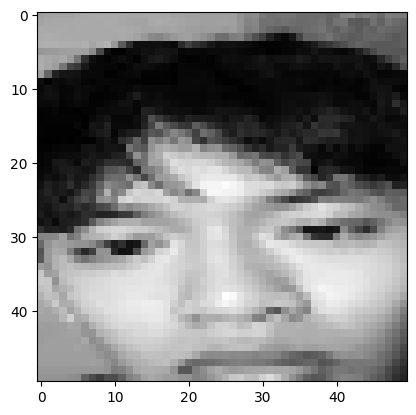

In [ ]:
plt.imshow(images[30], cmap="gray")

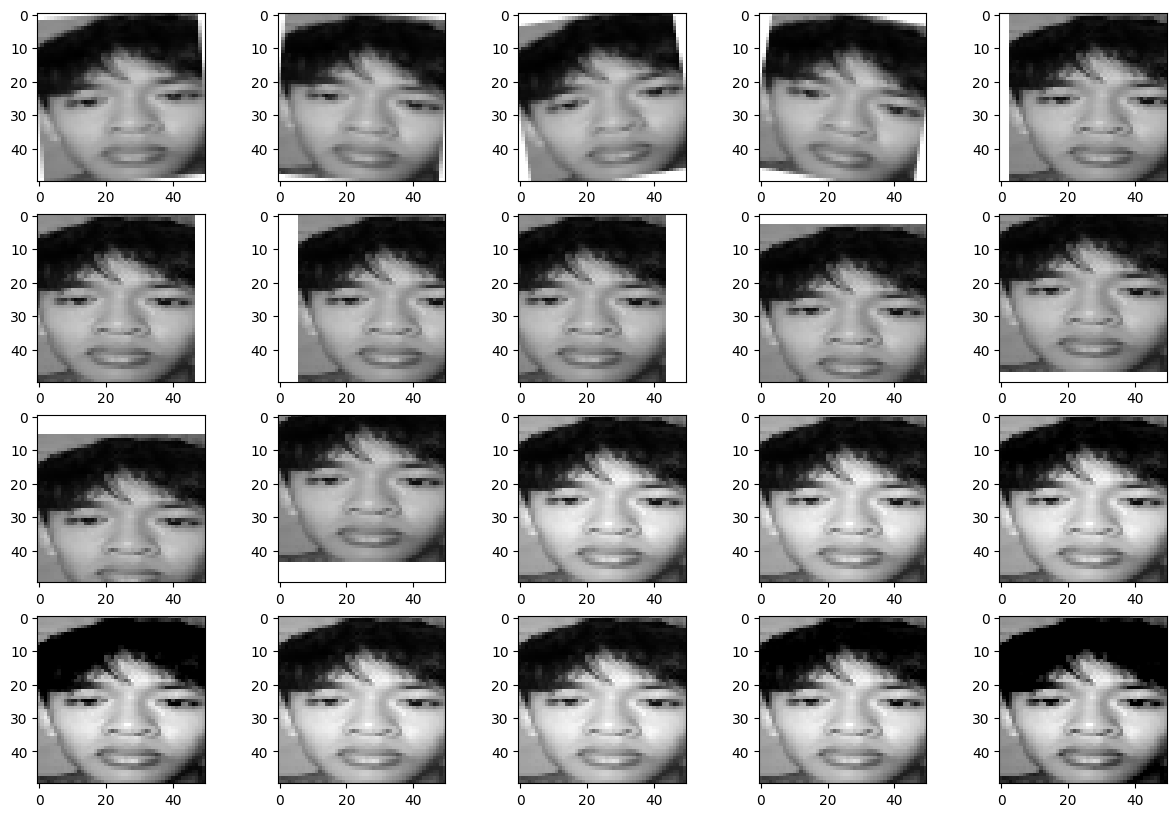

In [ ]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [ ]:
len(augmented_images), len(augmented_names)

(2040, 2040)

In [ ]:
images.extend(augmented_images)
names.extend(augmented_names)

In [ ]:
len(images), len(names)

(2142, 2142)

In [ ]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Muhamad Fajar', 1071)
('Muhammad Nurfathullah', 1071)


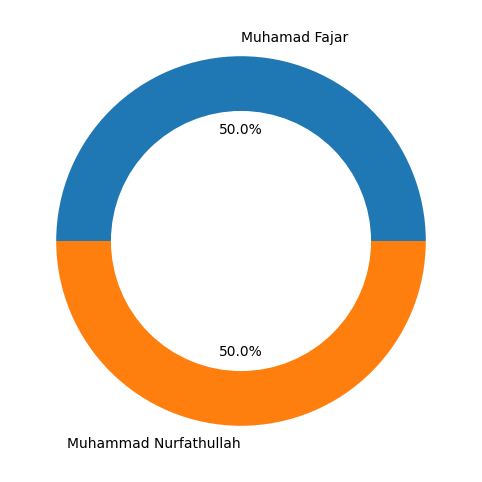

In [ ]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [ ]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [ ]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

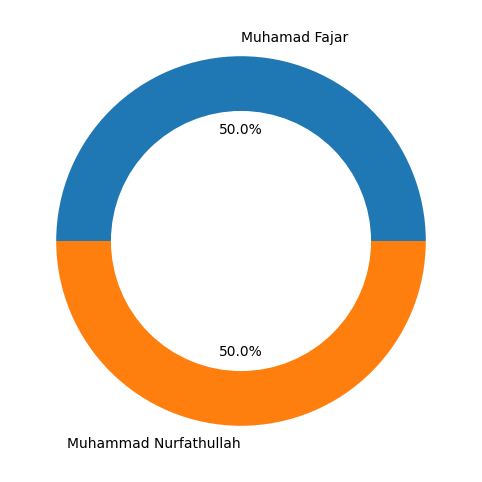

In [ ]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [ ]:
len(names)

2000

In [ ]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [ ]:
print("number of class :", len(labels))
print(labels)

number of class : 2
['Muhamad Fajar' 'Muhammad Nurfathullah']


In [ ]:
print(name_vec)

[0 0 0 ... 1 1 1]


In [ ]:
print(categorical_name_vec)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(1700, 50, 50) (1700, 2) (300, 50, 50) (300, 2)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
x_train.shape, x_test.shape

((1700, 50, 50, 1), (300, 50, 50, 1))

In [ ]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  # equal to number of classes
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [ ]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                  

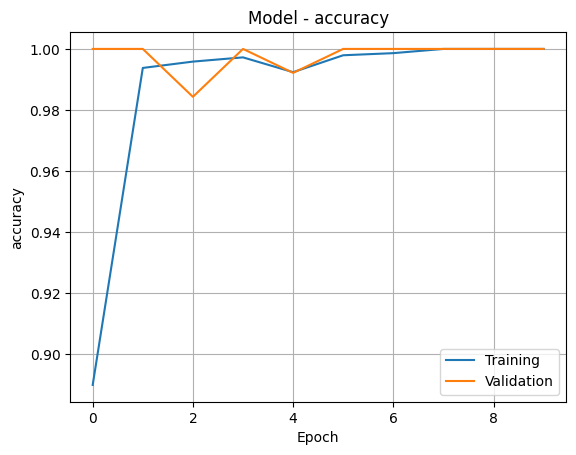

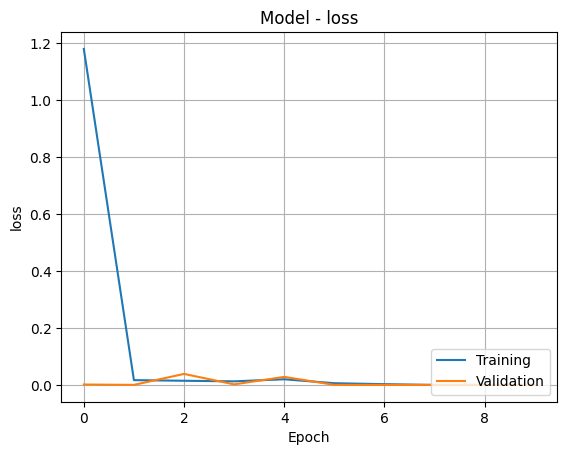

In [ ]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

In [ ]:
model.save("model-cnn-facerecognition.h5")

In [ ]:
# predict test data
y_pred=model.predict(x_test)

10/10 [==============================] - 2s 195ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

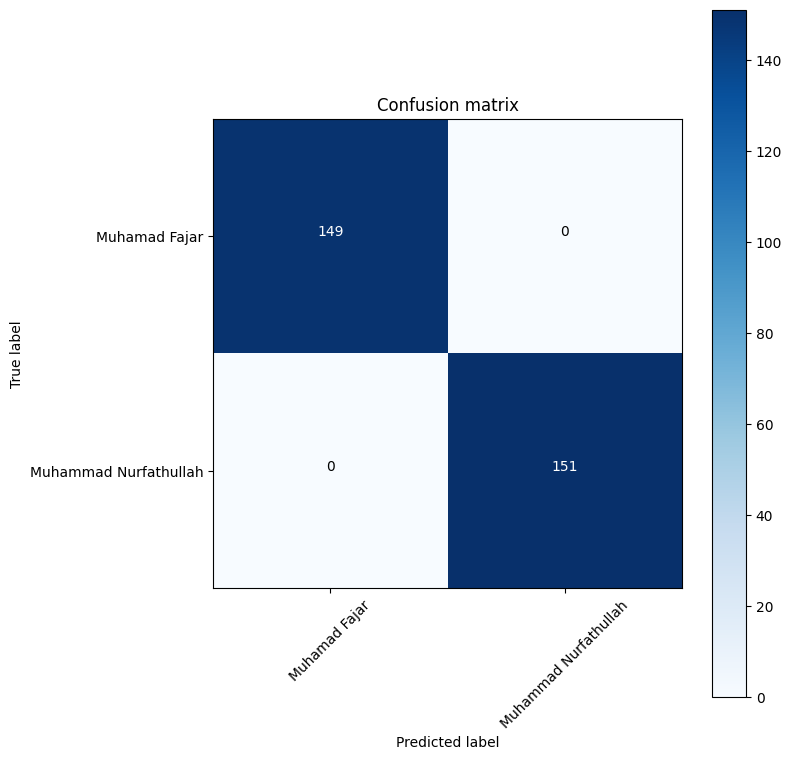

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')

In [ ]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                       precision    recall  f1-score   support

        Muhamad Fajar       1.00      1.00      1.00       149
Muhammad Nurfathullah       1.00      1.00      1.00       151

             accuracy                           1.00       300
            macro avg       1.00      1.00      1.00       300
         weighted avg       1.00      1.00      1.00       300



1/1 [==============================] - 0s 162ms/step
['Muhamad Fajar'] (100.00 %)


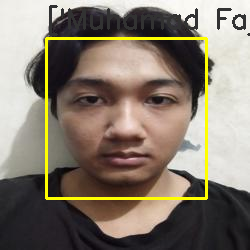

1/1 [==============================] - 0s 57ms/step
['Muhamad Fajar'] (100.00 %)


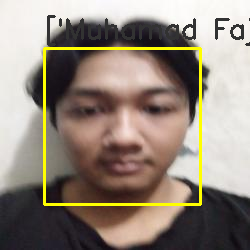

1/1 [==============================] - 0s 48ms/step
['Muhamad Fajar'] (100.00 %)


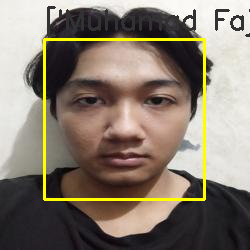

1/1 [==============================] - 0s 46ms/step
['Muhamad Fajar'] (100.00 %)


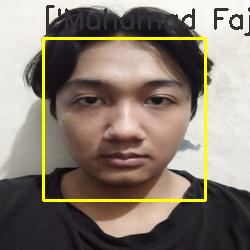

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (100.00 %)


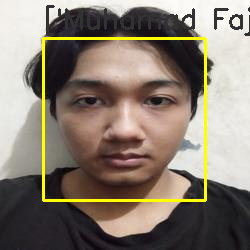

1/1 [==============================] - 0s 55ms/step
['Muhamad Fajar'] (100.00 %)


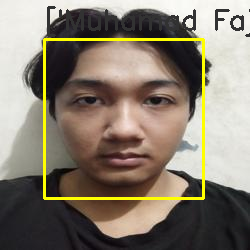

1/1 [==============================] - 0s 48ms/step
['Muhamad Fajar'] (100.00 %)


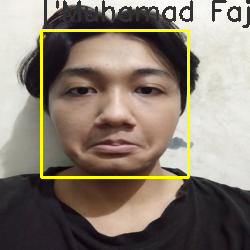

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (100.00 %)


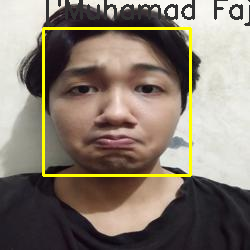

1/1 [==============================] - 0s 54ms/step
['Muhamad Fajar'] (100.00 %)


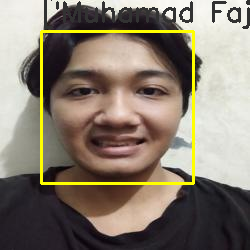

1/1 [==============================] - 0s 46ms/step
['Muhamad Fajar'] (100.00 %)


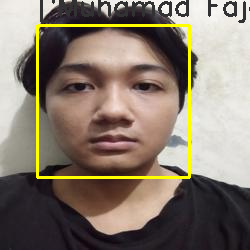

1/1 [==============================] - 0s 43ms/step
['Muhamad Fajar'] (100.00 %)


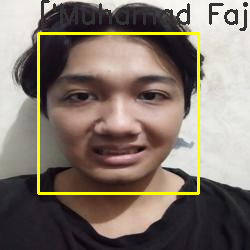

1/1 [==============================] - 0s 45ms/step
['Muhamad Fajar'] (100.00 %)


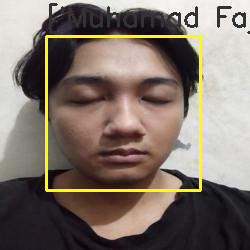

1/1 [==============================] - 0s 51ms/step
['Muhamad Fajar'] (99.97 %)


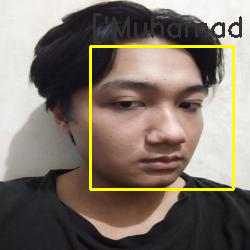

1/1 [==============================] - 0s 31ms/step
['Muhamad Fajar'] (100.00 %)


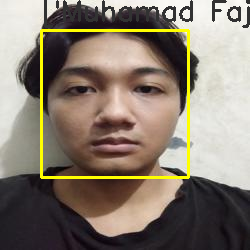

1/1 [==============================] - 0s 29ms/step
['Muhamad Fajar'] (99.99 %)


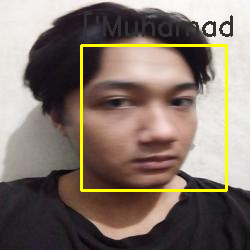

1/1 [==============================] - 0s 35ms/step
['Muhamad Fajar'] (100.00 %)


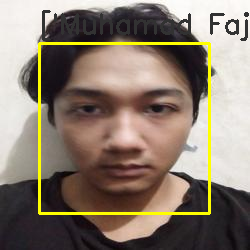

1/1 [==============================] - 0s 32ms/step
['Muhamad Fajar'] (100.00 %)


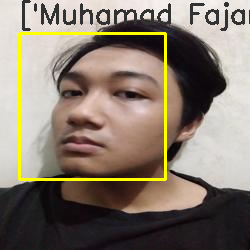

1/1 [==============================] - 0s 29ms/step
['Muhamad Fajar'] (94.37 %)


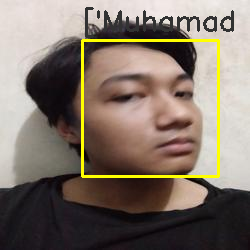

1/1 [==============================] - 0s 64ms/step
['Muhamad Fajar'] (100.00 %)


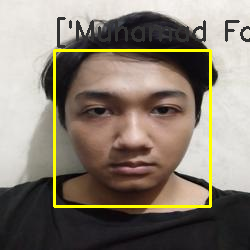

1/1 [==============================] - 0s 35ms/step
['Muhamad Fajar'] (100.00 %)


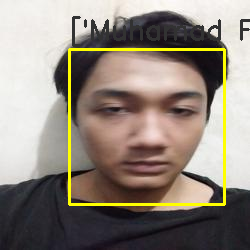

1/1 [==============================] - 0s 28ms/step
['Muhamad Fajar'] (100.00 %)


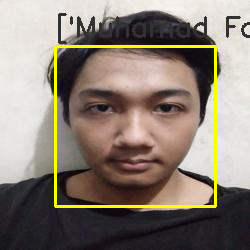

1/1 [==============================] - 0s 28ms/step
['Muhamad Fajar'] (100.00 %)


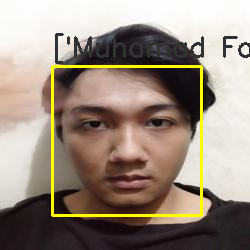

1/1 [==============================] - 0s 30ms/step
['Muhamad Fajar'] (100.00 %)


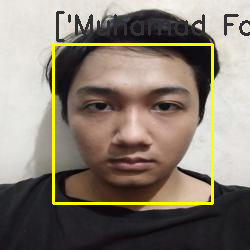

1/1 [==============================] - 0s 29ms/step
['Muhamad Fajar'] (100.00 %)


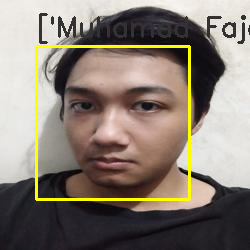

1/1 [==============================] - 0s 30ms/step
['Muhamad Fajar'] (100.00 %)


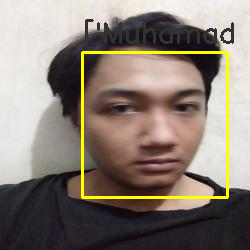

1/1 [==============================] - 0s 44ms/step
['Muhamad Fajar'] (100.00 %)


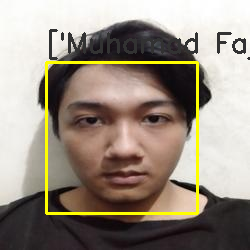

1/1 [==============================] - 0s 34ms/step
['Muhamad Fajar'] (100.00 %)


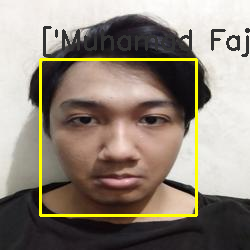

1/1 [==============================] - 0s 51ms/step
['Muhamad Fajar'] (100.00 %)


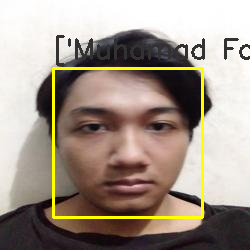

1/1 [==============================] - 0s 48ms/step
['Muhamad Fajar'] (100.00 %)


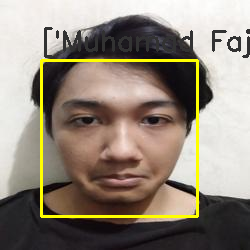

1/1 [==============================] - 0s 46ms/step
['Muhamad Fajar'] (100.00 %)


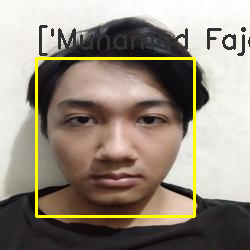

1/1 [==============================] - 0s 45ms/step
['Muhamad Fajar'] (100.00 %)


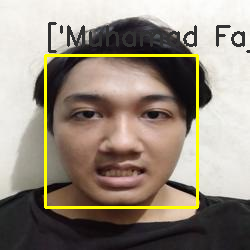

1/1 [==============================] - 0s 45ms/step
['Muhamad Fajar'] (100.00 %)


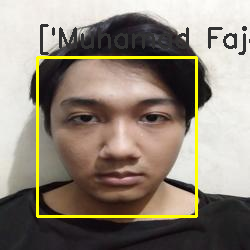

1/1 [==============================] - 0s 43ms/step
['Muhamad Fajar'] (100.00 %)


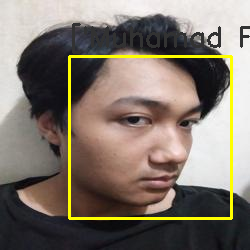

1/1 [==============================] - 0s 48ms/step
['Muhamad Fajar'] (100.00 %)


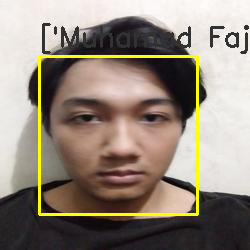

1/1 [==============================] - 0s 46ms/step
['Muhamad Fajar'] (100.00 %)


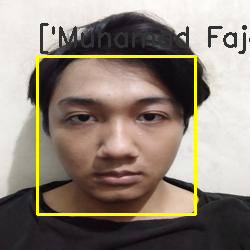

1/1 [==============================] - 0s 44ms/step
['Muhamad Fajar'] (100.00 %)


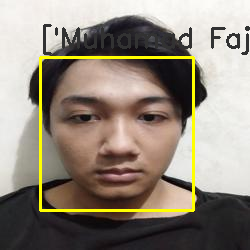

1/1 [==============================] - 0s 45ms/step
['Muhamad Fajar'] (100.00 %)


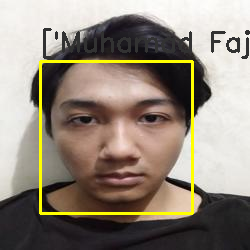

1/1 [==============================] - 0s 46ms/step
['Muhamad Fajar'] (100.00 %)


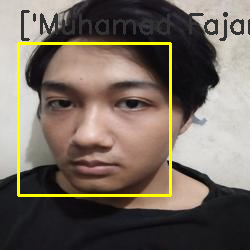

1/1 [==============================] - 0s 48ms/step
['Muhamad Fajar'] (100.00 %)


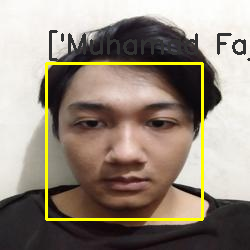

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (100.00 %)


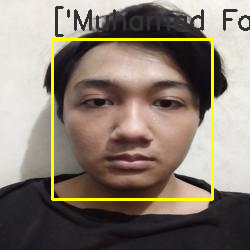

1/1 [==============================] - 0s 56ms/step
['Muhamad Fajar'] (100.00 %)


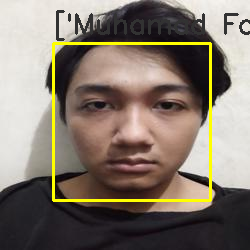

1/1 [==============================] - 0s 43ms/step
['Muhamad Fajar'] (100.00 %)


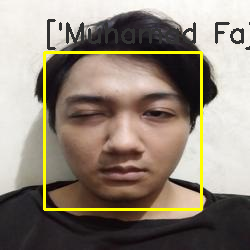

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (100.00 %)


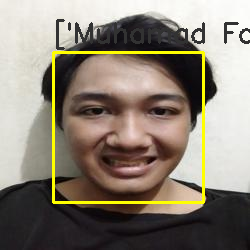

1/1 [==============================] - 0s 45ms/step
['Muhamad Fajar'] (99.99 %)


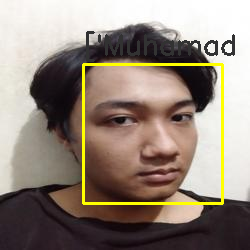

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (100.00 %)


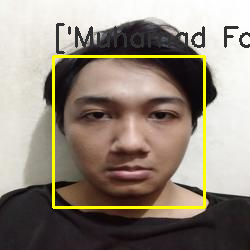

1/1 [==============================] - 0s 52ms/step
['Muhamad Fajar'] (100.00 %)


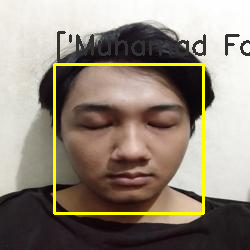

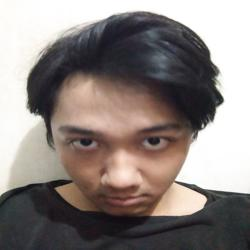

1/1 [==============================] - 0s 44ms/step
['Muhamad Fajar'] (99.97 %)


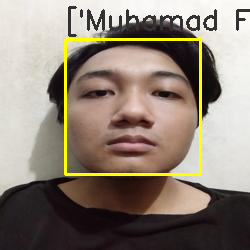

1/1 [==============================] - 0s 44ms/step
['Muhamad Fajar'] (100.00 %)


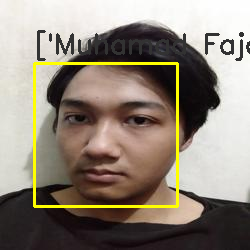

1/1 [==============================] - 0s 44ms/step
['Muhamad Fajar'] (100.00 %)


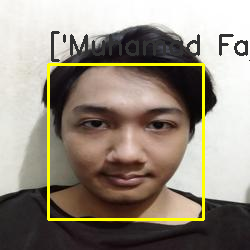

1/1 [==============================] - 0s 42ms/step
['Muhamad Fajar'] (100.00 %)


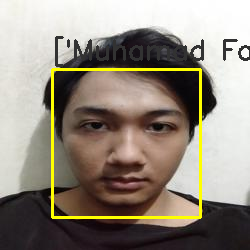

Jumlah gambar yang terprediksi tepat: 0
Jumlah gambar yang gagal terprediksi: 0
Jumlah gambar yang salah terprediksi: 50
Akurasi prediksi gambar : 0.0 %


In [ ]:
import cv2
import os
from keras.models import load_model
from google.colab.patches import cv2_imshow

# Load Haar Cascade model for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load Keras CNN model for face recognition
model = load_model("model-cnn-facerecognition.h5")
# Set the path to the directory containing the images
image_dir = "drive/MyDrive/dataset/Muhamad Fajar"
test=0
test2=0
test3=0
# Loop through each file in the directory
for filename in os.listdir(image_dir):
    
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        
        # Load the image from file
        img = cv2.imread(os.path.join(image_dir, filename))

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image using Haar Cascade classifier
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        # Loop through each detected face
        for (x, y, w, h) in faces:

            # Crop the detected face from the image
            face_img = gray[y:y+h, x:x+w]

            # Resize the face image to fit the input size of the Keras model
            face_img = cv2.resize(face_img, (50, 50))

            # Reshape the face image to match the input shape of the Keras model
            face_img = face_img.reshape(1, 50, 50, 1)

            # Make prediction using the Keras model
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100

            # If the confidence level is higher than 80%, label the face with the recognized person's name
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
                print(label_text)
                if str(labels[idx]).strip('[]').strip()== "'Muhamad Fajar '":
                  test += 1
                else : 
                  test3 += 1
            else :
                label_text = "N/A"
                print(label_text)
                test2 += 1

            # Draw a rectangle around the detected face and label it with the recognized person's name
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
            img = cv2.putText(img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (50,50,50), 2)

        # Display the output image
        cv2_imshow(img)
        cv2.waitKey(0)
cv2.destroyAllWindows()
total = len([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")])
akurasi = test/total*100
print("Jumlah gambar yang terprediksi tepat:",test)
print("Jumlah gambar yang gagal terprediksi:",test2)
print("Jumlah gambar yang salah terprediksi:",test3)
print("Akurasi prediksi gambar :",round(akurasi, 2) ,"%")

1/1 [==============================] - 0s 100ms/step
['Muhammad Nurfathullah'] (96.21 %)


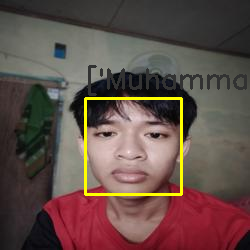

1/1 [==============================] - 0s 28ms/step
['Muhammad Nurfathullah'] (94.15 %)


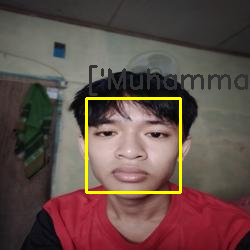

1/1 [==============================] - 0s 31ms/step
['Muhammad Nurfathullah'] (99.62 %)


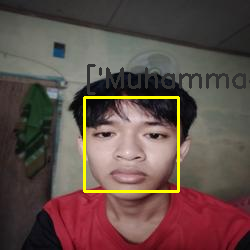

1/1 [==============================] - 0s 31ms/step
['Muhammad Nurfathullah'] (99.24 %)


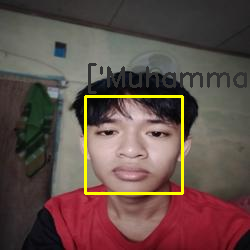

1/1 [==============================] - 0s 28ms/step
['Muhamad Fajar'] (100.00 %)


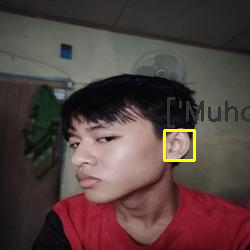

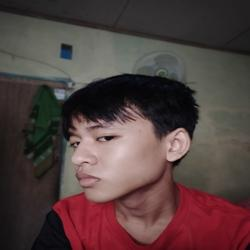

1/1 [==============================] - 0s 28ms/step
['Muhammad Nurfathullah'] (99.34 %)


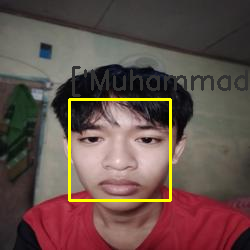

1/1 [==============================] - 0s 29ms/step
['Muhammad Nurfathullah'] (99.11 %)


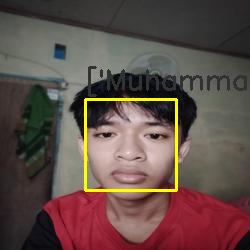

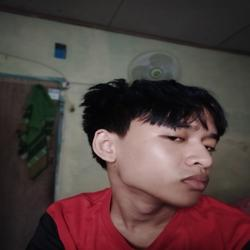

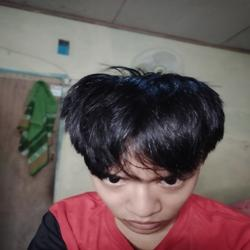

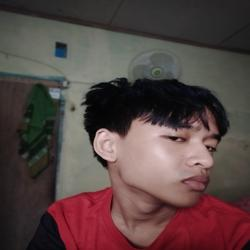

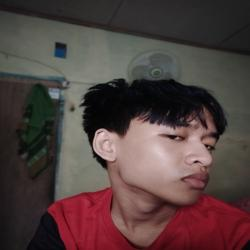

1/1 [==============================] - 0s 31ms/step
['Muhamad Fajar'] (100.00 %)


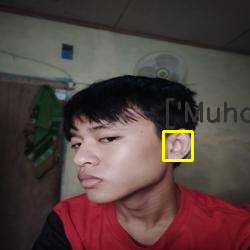

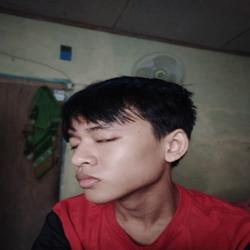

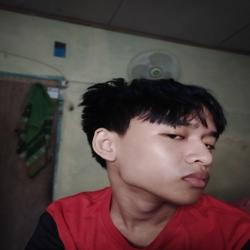

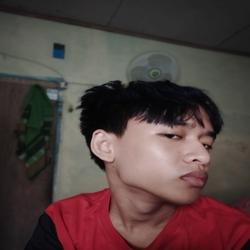

1/1 [==============================] - 0s 32ms/step
['Muhamad Fajar'] (100.00 %)


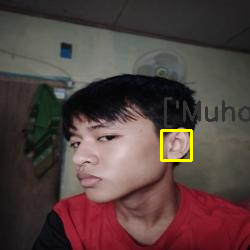

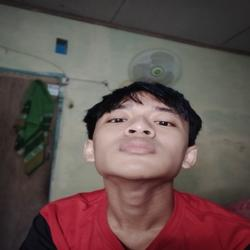

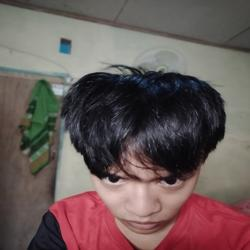

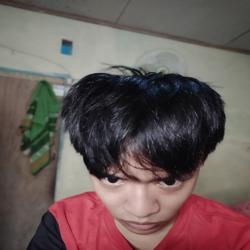

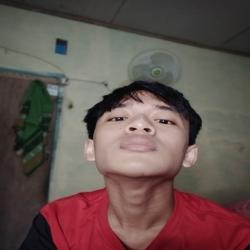

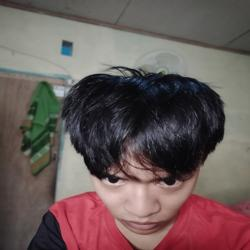

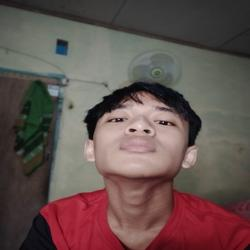

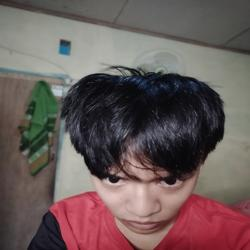

1/1 [==============================] - 0s 29ms/step
['Muhammad Nurfathullah'] (83.36 %)


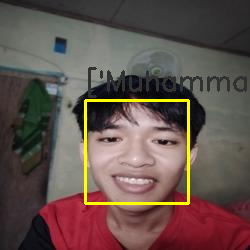

1/1 [==============================] - 0s 28ms/step
['Muhammad Nurfathullah'] (87.37 %)


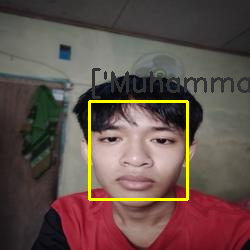

1/1 [==============================] - 0s 29ms/step
N/A


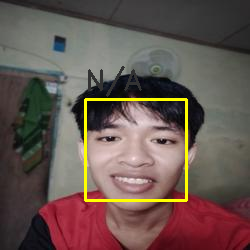

1/1 [==============================] - 0s 35ms/step
N/A


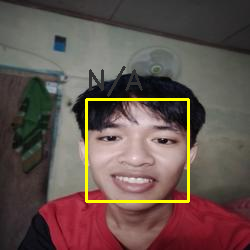

1/1 [==============================] - 0s 28ms/step
N/A


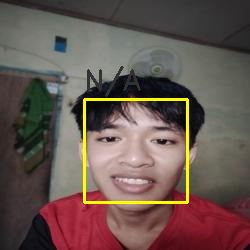

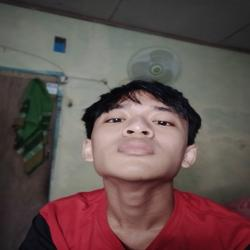

1/1 [==============================] - 0s 36ms/step
['Muhammad Nurfathullah'] (99.90 %)


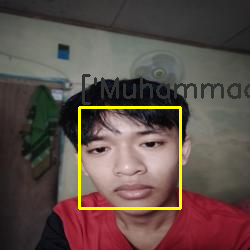

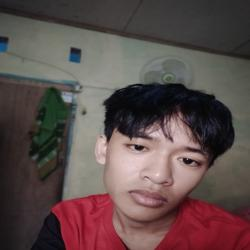

1/1 [==============================] - 0s 35ms/step
['Muhammad Nurfathullah'] (84.93 %)


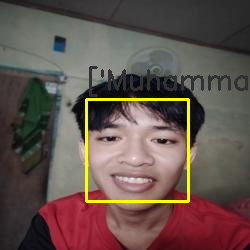

1/1 [==============================] - 0s 49ms/step
['Muhamad Fajar'] (80.92 %)


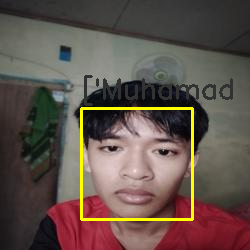

1/1 [==============================] - 0s 59ms/step
['Muhammad Nurfathullah'] (99.98 %)


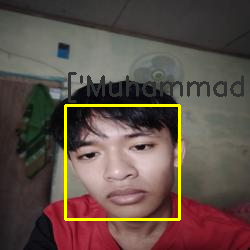

1/1 [==============================] - 0s 66ms/step
['Muhammad Nurfathullah'] (99.98 %)


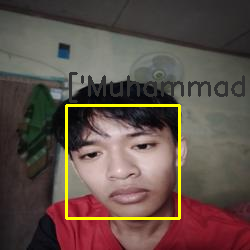

1/1 [==============================] - 0s 43ms/step
['Muhammad Nurfathullah'] (99.96 %)


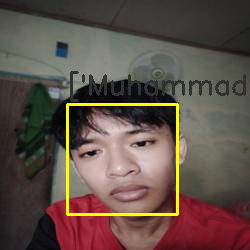

1/1 [==============================] - 0s 42ms/step
['Muhammad Nurfathullah'] (99.99 %)


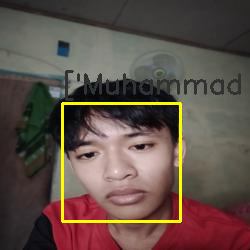

1/1 [==============================] - 0s 45ms/step
N/A


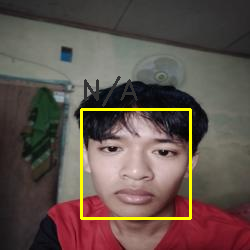

1/1 [==============================] - 0s 42ms/step
N/A


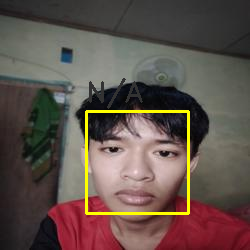

1/1 [==============================] - 0s 52ms/step
N/A


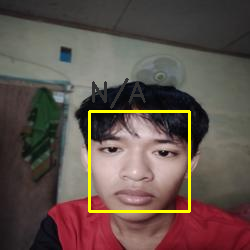

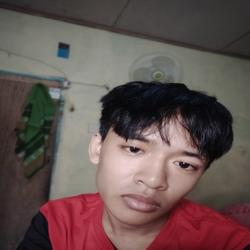

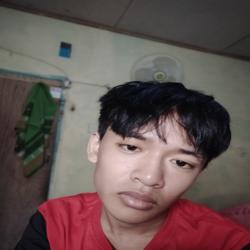

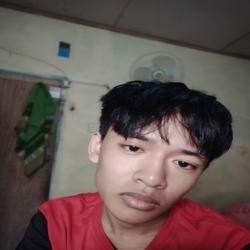

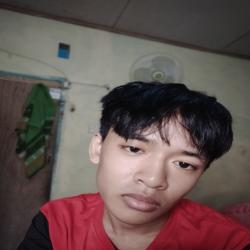

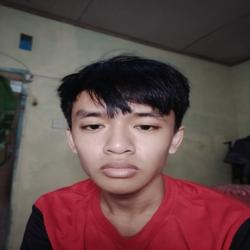

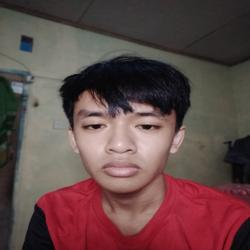

1/1 [==============================] - 0s 45ms/step
['Muhammad Nurfathullah'] (100.00 %)


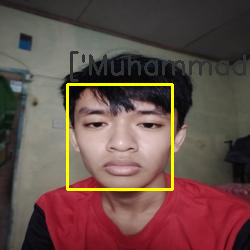

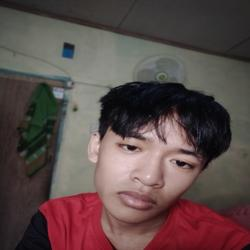

1/1 [==============================] - 0s 44ms/step
['Muhammad Nurfathullah'] (100.00 %)


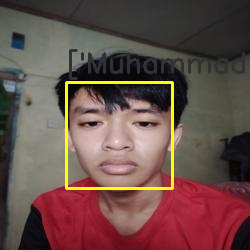

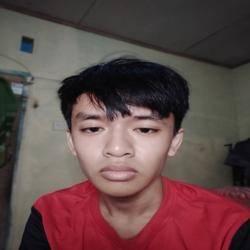

Jumlah gambar yang terprediksi tepat: 16
Jumlah gambar yang gagal terprediksi: 6
Jumlah gambar yang salah terprediksi: 4
Akurasi prediksi gambar : 31.37 %


In [ ]:
import cv2
import os
from keras.models import load_model
from google.colab.patches import cv2_imshow

# Load Haar Cascade model for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load Keras CNN model for face recognition
model = load_model("model-cnn-facerecognition.h5")
# Set the path to the directory containing the images
image_dir = "drive/MyDrive/dataset/Muhammad Nurfathullah"
test=0
test2=0
test3=0
# Loop through each file in the directory
for filename in os.listdir(image_dir):
    
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        
        # Load the image from file
        img = cv2.imread(os.path.join(image_dir, filename))

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image using Haar Cascade classifier
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        # Loop through each detected face
        for (x, y, w, h) in faces:

            # Crop the detected face from the image
            face_img = gray[y:y+h, x:x+w]

            # Resize the face image to fit the input size of the Keras model
            face_img = cv2.resize(face_img, (50, 50))

            # Reshape the face image to match the input shape of the Keras model
            face_img = face_img.reshape(1, 50, 50, 1)

            # Make prediction using the Keras model
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100

            # If the confidence level is higher than 80%, label the face with the recognized person's name
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
                print(label_text)
                if str(labels[idx]).strip('[]').strip()== "'Muhammad Nurfathullah'":
                  test += 1
                else : 
                  test3 += 1
            else :
                label_text = "N/A"
                print(label_text)
                test2 += 1

            # Draw a rectangle around the detected face and label it with the recognized person's name
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
            img = cv2.putText(img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (50,50,50), 2)

        # Display the output image
        cv2_imshow(img)
        cv2.waitKey(0)
cv2.destroyAllWindows()
total = len([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")])
akurasi = test/total*100
print("Jumlah gambar yang terprediksi tepat:",test)
print("Jumlah gambar yang gagal terprediksi:",test2)
print("Jumlah gambar yang salah terprediksi:",test3)
print("Akurasi prediksi gambar :",round(akurasi, 2) ,"%")